<a href="https://colab.research.google.com/github/mingyucai/LQR_CBF_rrtStar/blob/main/LQR_car_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# continuous LQR: https://github.com/stephentu/zero-to-cartpole/blob/master/swing-up.ipynb

# iLQR: https://studywolf.wordpress.com/2016/02/03/the-iterative-linear-quadratic-regulator-method/
# iLQR paper: https://homes.cs.washington.edu/~todorov/papers/TassaIROS12.pdf  implementation: https://github.com/anassinator/ilqr

In [6]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

def dlqr(A,B,Q,R):
    """
    Solve the discrete time lqr controller.
    x[k+1] = A x[k] + B u[k]
    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    """
    # first, solve the ricatti equation
    P = np.matrix(scipy.linalg.solve_discrete_are(A, B, Q, R))
    # compute the LQR gain
    K = np.matrix(scipy.linalg.inv(B.T*P*B+R)*(B.T*P*A))

    eigVals, eigVecs = scipy.linalg.eig(A-B*K)
    
    return -K

def lqr(A,B,Q,R):
  X = np.matrix(scipy.linalg.solve_continuous_are(A, B, Q, R))
  #compute the LQR gain
  K = np.matrix(scipy.linalg.inv(R)*(B.T*X))

  eigVals, eigVecs = scipy.linalg.eig(A-B*K)

  return -K

In [7]:
def getB(yaw, dt):
  B = np.matrix([[np.cos(yaw) * dt, 0], [np.sin(yaw) * dt, 0], [0, dt]])
  return B

A = np.matrix([[1.0, 0, 0],[0 , 1.0, 0], [0, 0, 1.0]])
Q = np.matrix("0.5 0 0; 0 1 0; 0 0 1")
R = np.matrix("0.01 0; 0 0.01")

# print(xk[2, 0])
# print(R)
xd = np.matrix([[10], [20], [np.pi/2]])
xk = np.matrix([[0], [0], [0]])
print(xk.shape)
dt = 0.1
yaw = xk[2, 0]
B= getB(yaw, dt)

# Optional Variables
max_linear_velocity = 3.0 # meters per second
max_angular_velocity = 1.5708 # radians per second


(3, 1)


In [8]:
def dLQR(A, B, Q, R):
    
    N = 50
 
    # Create a list of N + 1 elements
    P = [None] * (N + 1)
     
    Qf = Q
 
    # LQR via Dynamic Programming
    P[N] = Qf
 
    # For i = N, ..., 1
    for i in range(N, 0, -1):
        P[i-1] = Q + A.T @ P[i] @ A - (A.T @ P[i] @ B) @ np.linalg.pinv(
            R + B.T @ P[i] @ B) @ (B.T @ P[i] @ A)   

    # Create a list of N elements
    K = [None] * N
    u = [None] * N

    P1 = P[N-1]

    K1 = -np.linalg.inv(R + B.T @ P[N] @ B) @ B.T @ P[N] @ A
    

    return K1#K[N-1]

(3, 1)
[[-4.90969223e-06]
 [ 1.12095772e-05]]
[[1.40119715e-05 0.00000000e+00]
 [5.00000000e-01 0.00000000e+00]
 [0.00000000e+00 5.00000000e-01]]
[[ 9.65661517]
 [20.00000982]
 [ 1.57077391]] [[10.        ]
 [20.        ]
 [ 1.57079633]]
error 0.34338482749855587


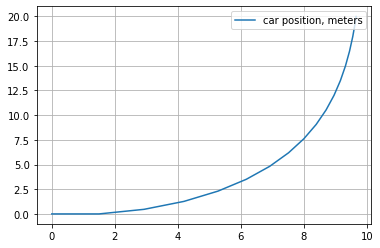

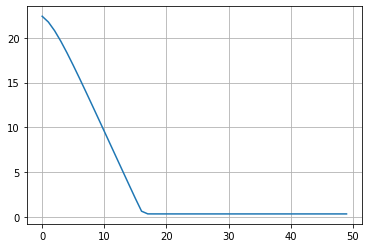

In [9]:
def getB(yaw, dt):
  B = np.matrix([[np.cos(yaw) * dt, 0], [np.sin(yaw) * dt, 0], [0, dt]])
  return B

A = np.matrix([[1.0, 0, 0],[0 , 1.0, 0], [0, 0, 1.0]])
Q = np.matrix("0.5 0 0; 0 0.5 0; 0 0 0.01")
R = np.matrix("0.01 0; 0 0.01")

xd = np.matrix([[10], [20], [np.pi/2]])
xk = np.matrix([[0], [0], [0]])
print(xk.shape)
dt = 0.1
yaw = xk[2, 0]
B= getB(yaw, dt)

# Optional Variables
max_linear_velocity = 3.0 # meters per second
max_angular_velocity = 1.5708 # radians per second

nsteps = 50
time = np.linspace(0, 2, nsteps, endpoint=True)
xd = np.matrix([[10], [20], [np.pi/2]])
xk = np.matrix([[0], [0], [0]])
dt = 0.5

X = []
Y = []
T = []
U = []
errors = []
max_linear_velocity = 3.0 # meters per second
max_angular_velocity = 1.5708 # radians per second

for t in time:
    xe = xk - xd
    errors.append( np.linalg.norm(xe))

    yaw = xk[2, 0]
    B= getB(yaw, dt) 
    K = dLQR(A,B,Q,R)

    uk = K*xe
    # clip does not work for X axis
    uk = np.clip(uk, -max_linear_velocity, max_linear_velocity)

    X.append(xk[0, 0])
    Y.append(xk[1, 0])

    xk = A*xk + B*uk

print(uk)
print(B)
print(xk, xd)
print('error', np.linalg.norm(xe))

plt.plot(X, Y, label="car position, meters")

plt.legend(loc='upper right')
plt.grid()
plt.show()

plt.plot(errors, label="error")
plt.grid()
plt.show()

error 9.155133597044475e-16


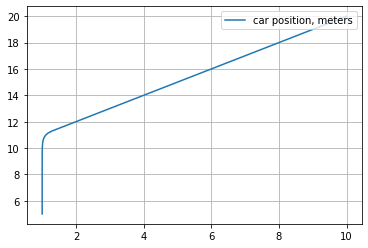

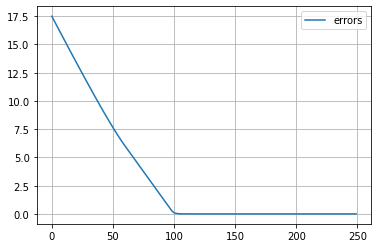

In [10]:
# linear velocity dynnamics

dt = 0.05

A = np.matrix([[1, 0],[0 , 1]])
B = np.matrix([[dt, 0], [0, dt]])

Q = np.matrix("1 0; 0 1")
R = np.matrix("0.01 0; 0 0.01")

Q = np.matrix("1 0; 0 1")
R = np.matrix("0.01 0; 0 0.01")
K = dlqr(A,B,Q,R)

nsteps = 250
time = np.linspace(0, 2, nsteps, endpoint=True)
xk = np.matrix("10; 20")
xd = xd = np.matrix("1; 5")
max_speed = 3.0

X = []
Y = []
T = []
U = []
errors = []
for t in time:
    xe = xk - xd
    uk = K*xe

    # clip the control based on acuator limitation
    uk = np.clip(uk, -max_speed, max_speed)

    # check the condition of control limitation
    assert abs(uk[1, 0]) <= 3.0 or abs(uk[0, 0]) <= 3.0, "control inputs execeed limitation'"
    
    X.append(xk[0, 0])
    Y.append(xk[1, 0])
    errors.append( np.linalg.norm(xe))

    xk = A*xk + B*uk
    
print('error', np.linalg.norm(xe))
plt.plot(X, Y, label="car position, meters")
plt.legend(loc='upper right')
plt.grid()
plt.show()


plt.plot(errors, label="errors")
plt.legend(loc='upper right')
plt.grid()
plt.show()

LQR for linear acceleration model:  [[-8.72031057 -0.         -5.22725224 -0.        ]
 [-0.         -8.72031057 -0.         -5.22725224]]
error 9.772254496625198e-15


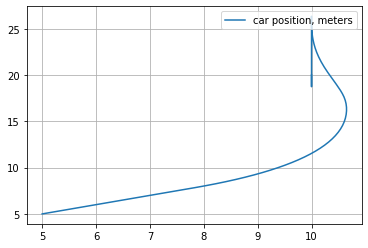

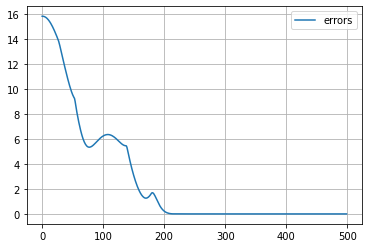

In [11]:
# /home/mingyucai/git/LQR_CBF_rrtStar/~/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py

# linear dynnamics (acceleration)

dt = 0.05

A = np.matrix([[1, 0, dt, 0],[0 , 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])
B = np.matrix([[0, 0], [0, 0], [dt, 0], [0, dt]])
Q = np.matrix("1 0 0 0; 0 1 0 0; 0 0 0.1 0; 0 0 0 0.1")
R = np.matrix("0.01 0; 0 0.01")

K = dlqr(A,B,Q,R)
print("LQR for linear acceleration model: ", K)

nsteps = 500
time = np.linspace(0, 2, nsteps, endpoint=True)
xk = np.matrix("5; 5; 0; 0")
xd = xd = np.matrix("10; 20; 0; 0")

X = []
Y = []
T = []
U = []
errors = []
for t in time:
    xe = xk - xd
    uk = K*xe
    uk = np.clip(uk, -3.0, 3.0)  # control limitation

    X.append(xk[0, 0])
    Y.append(xk[1, 0])
    errors.append( np.linalg.norm(xe))

    xk = A*xk + B*uk

print('error', np.linalg.norm(xe))

plt.plot(X, Y, label="car position, meters")
plt.legend(loc='upper right')
plt.grid()
plt.show()


plt.plot(errors, label="errors")
plt.legend(loc='upper right')
plt.grid()
plt.show()


In [12]:
# nonlinear dynamic system

# dxdt = v * cos(theta)
# dydt = v * sin(theta)
# dthetadt = yaw

# System Modeling
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import cvxpy as cp

import matplotlib.pyplot as plt

import time

"""
Control problem statement.
"""

N = 3  # number of state variables
M = 2  # number of control variables
DT = 0.2  

def get_linear_model(x_bar, u_bar):
    """
    Computes the LTI approximated state space model x' = Ax + Bu + C
    """
    x = x_bar[0]
    y = x_bar[1]
    theta = x_bar[2]

    v = u_bar[0]
    yaw = u_bar[1]

    A = np.zeros((N, N))
    A[0, 2] = -v * np.sin(theta)
    A[1, 2] = v * np.sin(theta)
    A_lin = np.eye(N) + DT * A

    B = np.zeros((N, M))
    B[0, 0] = np.cos(theta)
    B[1, 1] = np.sin(theta)
    B[2, 1] = 1
    B_lin = DT * B

    f_xu = np.array(
        [v * np.cos(theta), v * np.sin(theta), theta]
    ).reshape(N, 1)
    C_lin = DT * (
        f_xu - np.dot(A, x_bar.reshape(N, 1)) - np.dot(B, u_bar.reshape(M, 1))
    )

    return np.round(A_lin, 4), np.round(B_lin, 4), np.round(C_lin, 4)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[0.1414 0.    ]
 [0.     0.1414]
 [0.     0.2   ]]
[[0.    ]
 [0.    ]
 [0.1571]]
LQR Gain for nonlinear velocity model:  [[-3.53553387  0.          0.        ]
 [ 0.         -4.65224012 -0.06580255]]
error 0.48174725849030586
[[49.80174013]
 [ 9.56094027]
 [32.06105357]]


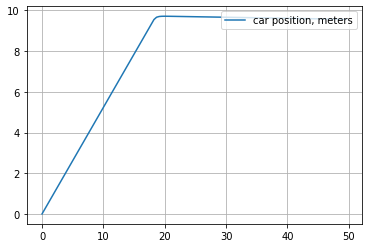

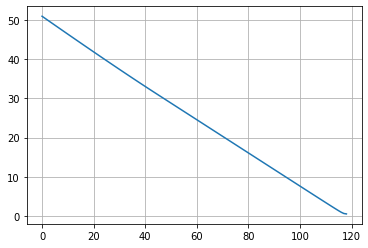

In [14]:
xd = np.matrix([[50], [10], [np.pi/4]])
ud = np.matrix([[0], [0]])

A, B, C = get_linear_model(xd, ud)

print(A)
print(B)
print(C)

Q = np.matrix("0.5 0 0; 0 1 0; 0 0 0.01")
R = np.matrix("0.01 0; 0 0.01")
K = dLQR(A,B,Q,R)

print("LQR Gain for nonlinear velocity model: ", K)

nsteps = 500
time = np.linspace(0, 2, nsteps, endpoint=True)
xk = np.matrix([[0], [0], [0]])
dt = 0.5

max_linear_velocity = 3.0 # meters per second
max_angular_velocity = 1.5708 # radians per second


X = []
Y = []
T = []
U = []
errors = []
for t in time:
    xe = xk - xd
    errors.append( np.linalg.norm(xe[0:2]))


    uk = K*xe
    uk[0] = np.clip(uk[0], -max_linear_velocity, max_linear_velocity)
    uk[1] = np.clip(uk[1], -max_angular_velocity, max_angular_velocity)
    if np.linalg.norm(xe[0:2]) < 0.5:
      break

    X.append(xk[0, 0])
    Y.append(xk[1, 0])

    xk = A*xk + B*uk + C

print('error', np.linalg.norm(xe[0:2]))

print(xk)
plt.plot(X, Y, label="car position, meters")

plt.legend(loc='upper right')
plt.grid()
plt.show()

plt.plot(errors, label="error")
plt.grid()
plt.show()

In [15]:
# nonlinear acceleration dynamic system

# dxdt = v * cos(theta)
# dydt = v * sin(theta)
# dvdt = a
# dthetadt = yaw

# System Modeling
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import cvxpy as cp

import matplotlib.pyplot as plt

import time

"""
Control problem statement.
"""

N = 4  # number of state variables
M = 2  # number of control variables
DT = 0.2  

# nonlinear acceleration model
def get_linear_acc_model(x_bar, u_bar):
    """
    Computes the LTI approximated state space model x' = Ax + Bu + C
    """

    L = 0.3  # vehicle wheelbase

    x = x_bar[0]
    y = x_bar[1]
    v = x_bar[2]
    theta = x_bar[3]

    a = u_bar[0]
    delta = u_bar[1]

    A = np.zeros((N, N))
    A[0, 2] = np.cos(theta)
    A[0, 3] = -v * np.sin(theta)
    A[1, 2] = np.sin(theta)
    A[1, 3] = v * np.cos(theta)
    A[3, 2] = 0
    A_lin = np.eye(N) + DT * A

    B = np.zeros((N, M))
    B[2, 0] = 1
    B[3, 1] = 1
    B_lin = DT * B

    f_xu = np.array(
        [v * np.cos(theta), v * np.sin(theta), a, v * np.tan(delta) / L]
    ).reshape(N, 1)
    C_lin = DT * (
        f_xu - np.dot(A, x_bar.reshape(N, 1)) - np.dot(B, u_bar.reshape(M, 1))
    )

    return np.round(A_lin, 4), np.round(B_lin, 4), np.round(C_lin, 4)

[[ 1.      0.      0.1732 -0.01  ]
 [ 0.      1.      0.1     0.0173]
 [ 0.      0.      1.      0.    ]
 [ 0.      0.      0.      1.    ]]
[[0.  0. ]
 [0.  0. ]
 [0.2 0. ]
 [0.  0.2]]
[[ 0.0052]
 [-0.0091]
 [ 0.    ]
 [ 0.    ]]
LQR Gain for nonlinear acceleration model: 
[[ 0.          0.         -0.83333333  0.        ]
 [ 0.          0.          0.         -1.42857143]]
error 8.673254998513297
final state: 
[[17.17092927]
 [ 9.91411077]
 [ 0.1       ]
 [ 0.52359878]]


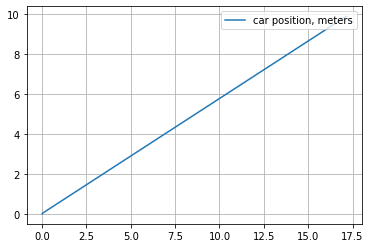

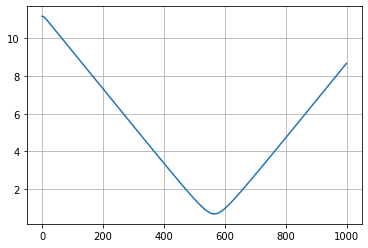

In [36]:
xd = np.matrix([[10], [5], [0.1], [np.pi/6]])
ud = np.matrix([[0], [0]])

xk = np.matrix([[0], [0], [0], [np.pi/4]])

A, B, C = get_linear_acc_model(xd, ud)

print(A)
print(B)
print(C)

Q = np.matrix("0.5 0 0 0; 0 0.5 0 0; 0 0 0.05 0; 0 0 0 0.1")
R = np.matrix("0.01 0; 0 0.01")
K = dLQR(A,B,Q,R)
print('LQR Gain for nonlinear acceleration model: ')
print(K)

nsteps = 1000
time = np.linspace(0, 2, nsteps, endpoint=True)
dt = 0.2

max_acc = 3.0 
max_angular_velocity = 1.5708 


X = []
Y = []
T = []
U = []
errors = []
for t in time:
    xe = xk - xd
    errors.append( np.linalg.norm(xe[0:2]))

    uk = K*xe
    uk[0] = np.clip(uk[0], -max_acc, max_acc)
    uk[1] = np.clip(uk[1], -max_angular_velocity, max_angular_velocity)
    if np.linalg.norm(xe[0:2]) < 0.5:
      print('goal reach')
      break

    X.append(xk[0, 0])
    Y.append(xk[1, 0])

    xk = A*xk + B*uk + C

print('error', np.linalg.norm(xe[0:2]))

print("final state: ")
print(xk)
plt.plot(X, Y, label="car position, meters")

plt.legend(loc='upper right')
plt.grid()
plt.show()

plt.plot(errors, label="error")
plt.grid()
plt.show()